# Methodological Foundation of a Numerical Taxonomy of Urban Form

This notebook serves as a template for morphometric assessment and generation of a taxonomy.

## Reproducible Python code to generate taxonomy

Complete morphometrics assessment from input data to taxonomy.

Input data:
 - building footprints
 - street network
 
This notebook is running the analysis on the sample of the data used in Prague case study. You can replace the sample with your own data, assuming that they are cleaned to a required standard. 

The sample is saved in `../files/sample.gpkg` with two layers named `buildings` and `streets`. `buildings` are Polygons, whilst `streets` are LineStrings.

Buildings data contain a single attribute column:

- `height` - building height in meters.

This notebook has been updated to work with `momepy` 0.5 and `geopandas` 0.10. The original work has been carried out using `momepy` 0.3 within the Docker container `darribas/gds_py:5.0`.

All data generated throughout the method are saved to files (unless commented out).

First we import all required libraries.

In [2]:
import warnings

import geopandas as gpd
import libpysal
import mapclassify
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from tqdm.auto import tqdm
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy

# we are using bleeding edge software that emits some warnings irrelevant for the current runtime
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
warnings.filterwarnings('ignore', message='.*overflow encountered*')
warnings.filterwarnings('ignore', message='.*index_parts defaults to True')
warnings.filterwarnings('ignore', message='.*`op` parameter is deprecated*')

/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check the input data

We load buildings and create unique ID.

In [3]:
path = "../files/sample.gpkg"
layer = "buildings"
buildings = gpd.read_file(path, layer=layer)

In [4]:
buildings

,height,geometry
0,21.0,"POLYGON ((-742025.710 -1046985.128, -742034.55..."
1,21.0,"POLYGON ((-742104.965 -1046933.503, -742097.25..."
2,3.5,"POLYGON ((-741593.210 -1046979.950, -741618.97..."
3,14.0,"POLYGON ((-741919.403 -1046959.955, -741901.95..."
4,17.5,"POLYGON ((-741925.795 -1046956.295, -741908.29..."
...,...,...
12879,21.0,"POLYGON ((-741769.470 -1041962.200, -741770.57..."
12880,14.0,"POLYGON ((-741832.430 -1041971.060, -741823.83..."
12881,21.0,"POLYGON ((-741859.560 -1041966.040, -741859.54..."
12882,21.0,"POLYGON ((-741926.911 -1041977.900, -741914.06..."


<Axes: >

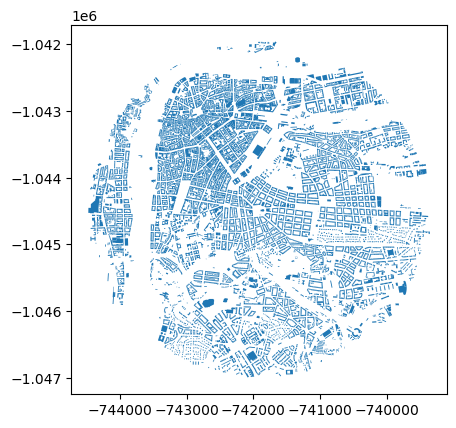

In [5]:
buildings.plot()

Let's create a persistent unique identifier for each building.

In [6]:
buildings["uID"] = range(len(buildings))

### Generate additional morphometric elements

Before we can start morhometrics we have to generate additional elements - tessellation and tessellation based blocks.

#### Morphological tessellation

Check input for tessellation. If the input data is clean, the check will result in zeros. The data does not have to be 100% clean (all 0). For example `Split features` may not cause any issue. 

In [7]:
check = mm.CheckTessellationInput(buildings)

Collapsed features  : 0
Split features      : 48
Overlapping features: 0


Generate tessellation limited to 100 m buffer. Beware, it is memory demanding.

**Note:** You may find that this step requires more memory that you are able to provide. In that case, you may consider using an [enclosed tessellation](http://docs.momepy.org/en/stable/user_guide/elements/enclosed.html) method instead. However, that would require minor adaptation of the code below as well.

In [8]:
limit = mm.buffered_limit(buildings, 100)

tessellation = mm.Tessellation(buildings, "uID", limit, verbose=False)
tessellation = tessellation.tessellation

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_17944/2640492488.py:3: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. `unique_id` of affected elements: [8468, 9450, 12837, 2142, 8575].
  tessellation = mm.Tessellation(buildings, "uID", limit, verbose=False)


In [9]:
tessellation

,uID,geometry
1,1,"POLYGON ((-742152.139 -1047034.980, -742150.61..."
6,6,"POLYGON ((-742345.550 -1046997.611, -742345.31..."
17,17,"POLYGON ((-742430.812 -1046928.508, -742431.11..."
43,43,"POLYGON ((-742435.381 -1046902.996, -742435.37..."
100,100,"POLYGON ((-742484.763 -1046864.307, -742484.89..."
...,...,...
12784,12784,"POLYGON ((-740625.244 -1042549.523, -740625.01..."
12768,12768,"POLYGON ((-740607.364 -1042553.548, -740607.94..."
12799,12799,"POLYGON ((-740579.284 -1042534.329, -740579.32..."
12832,12832,"POLYGON ((-740658.787 -1042414.238, -740659.34..."


<Axes: >

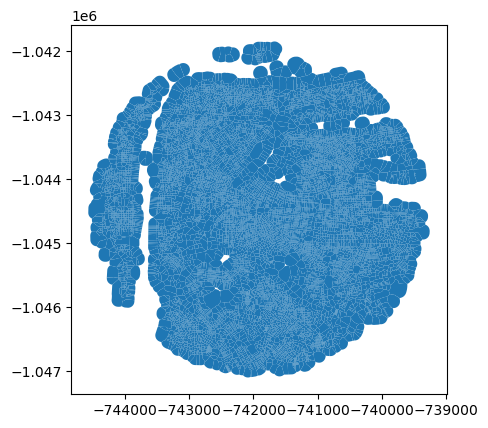

In [10]:
tessellation.plot()

We save tessellation to file. Note that this file is not part of the repository but can be fully created using the input sample and this notebook.

In [11]:
tessellation.to_file("../files/geometry.gpkg", layer="tessellation")

### Tessellation based blocks

To generate tessellation based blocks we also need street network, therefore we need to read it to GeoDataFrame first.

In [12]:
streets = gpd.read_file(path, layer='streets')

In [13]:
streets

,geometry
0,"LINESTRING (-742433.016 -1046264.808, -742436...."
1,"LINESTRING (-742488.604 -1046309.299, -742433...."
2,"LINESTRING (-742433.016 -1046264.808, -742403...."
3,"LINESTRING (-742591.967 -1046076.716, -742536...."
4,"LINESTRING (-742603.997 -1046092.676, -742591...."
...,...
2638,"LINESTRING (-743897.637 -1043082.976, -743862...."
2639,"LINESTRING (-739619.383 -1045339.927, -739547...."
2640,"LINESTRING (-741973.637 -1045689.976, -741938...."
2641,"LINESTRING (-743820.284 -1042903.602, -743822...."


<Axes: >

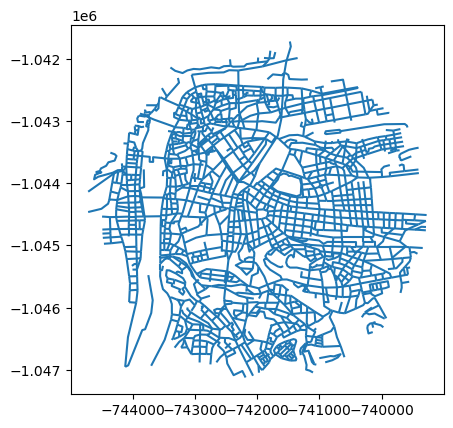

In [14]:
streets.plot()

To create blocks within the full `limit`, it is always safer to extend street network to the edge of the limit.

In [15]:
extended = mm.extend_lines(streets, tolerance=120, target=gpd.GeoSeries([limit.boundary]), barrier=buildings)

/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/pandas/core/arraylike.py:489: RuntimeWarning: invalid value encountered in intersection
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [16]:
blocks = mm.Blocks(tessellation, edges=extended, buildings=buildings, id_name='bID', unique_id='uID')
blocks_df = blocks.blocks  # get blocks df
buildings['bID'] = blocks.buildings_id.values  # get block ID
tessellation['bID'] = blocks.tessellation_id.values  # get block ID

/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/momepy/elements.py:626: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = libpysal.weights.Queen.from_dataframe(cut, silence_warnings=True)


#### Link streets

We need to understand which building belongs to which street segment. We link IDs together based on proximity.

In [17]:
streets["nID"] = range(len(streets))
buildings['nID'] = mm.get_network_id(buildings, streets, 'nID', min_size=300, verbose=False)
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

Finally, we save elements to a file.

In [18]:
path = '../files/geometry.gpkg'
tessellation.to_file(path, layer='tessellation', driver='GPKG')
buildings.to_file(path, layer='buildings', driver='GPKG')
blocks_df.to_file(path, layer='blocks', driver='GPKG')

## Measure primary characters

This part measures 74 primary morphometric characters.

It does save intermediate parquet files as a backup.

In [19]:
blocks = blocks_df

Note: 

- `height` is building height in meters. If you do not have it, skip affected lines.

In [20]:
buildings['floor_area'] = (buildings["height"] / 3.5) * buildings.area

In [22]:
buildings['sdbAre'] = mm.Area(buildings).series
buildings['sdbVol'] = mm.Volume(buildings, 'height', 'sdbAre').series
buildings['sdbPer'] = mm.Perimeter(buildings).series
buildings['sdbCoA'] = mm.CourtyardArea(buildings, 'sdbAre').series

buildings['ssbFoF'] = mm.FormFactor(buildings, 'sdbVol', 'sdbAre', heights="height").series
buildings['ssbVFR'] = mm.VolumeFacadeRatio(buildings, 'height', 'sdbVol', 'sdbPer').series
buildings['ssbCCo'] = mm.CircularCompactness(buildings, 'sdbAre').series
buildings['ssbCor'] = mm.Corners(buildings, verbose=False).series
buildings['ssbSqu'] = mm.Squareness(buildings, verbose=False).series
buildings['ssbERI'] = mm.EquivalentRectangularIndex(buildings, 'sdbAre', 'sdbPer').series
buildings['ssbElo'] = mm.Elongation(buildings).series

/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/momepy/shape.py:826: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/momepy/shape.py:947: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(cosine_angle))
/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/pandas/core/arraylike.py:489: RuntimeWarning: divide by zero encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)
/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/pandas/core/arraylike.py:489: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)
/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/pandas/core/arraylike.py:489: RuntimeWarning: divide by zero encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs

In [23]:
cencon = mm.CentroidCorners(buildings, verbose=False)
buildings['ssbCCM'] = cencon.mean
buildings['ssbCCD'] = cencon.std

/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/momepy/shape.py:1168: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


In [24]:
buildings['stbOri'] = mm.Orientation(buildings, verbose=False).series

tessellation['stcOri'] = mm.Orientation(tessellation, verbose=False).series
buildings['stbCeA'] = mm.CellAlignment(buildings, tessellation, 'stbOri', 'stcOri', 'uID', 'uID').series

/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/pandas/core/arraylike.py:489: RuntimeWarning: divide by zero encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)
/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/pandas/core/arraylike.py:489: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)
/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/pandas/core/arraylike.py:489: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [25]:
tessellation['sdcLAL'] = mm.LongestAxisLength(tessellation).series
tessellation['sdcAre'] = mm.Area(tessellation).series
tessellation['sscCCo'] = mm.CircularCompactness(tessellation, 'sdcAre').series
tessellation['sscERI'] = mm.EquivalentRectangularIndex(tessellation, 'sdcAre').series

/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/pandas/core/arraylike.py:489: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [26]:
buildings["mtbSWR"] = mm.SharedWallsRatio(buildings, "sdbPer").series

queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

buildings["mtbAli"] = mm.Alignment(buildings, queen_1, "uID", "stbOri", verbose=False).series
buildings["mtbNDi"] = mm.NeighborDistance(buildings, queen_1, "uID", verbose=False).series
tessellation["mtcWNe"] = mm.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["mdcAre"] = mm.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/momepy/distribution.py:135: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = gdf.sindex.query_bulk(gdf.geometry, predicate="intersects")
/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


In [27]:
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings["libNCo"] = mm.Courtyards(buildings, spatial_weights=buildings_q1, verbose=False).series
buildings["ldbPWL"] = mm.PerimeterWall(buildings, buildings_q1, verbose=False).series

blocks["ldkAre"] = mm.Area(blocks).series
blocks["ldkPer"] = mm.Perimeter(blocks).series
blocks["lskCCo"] = mm.CircularCompactness(blocks, "ldkAre").series
blocks["lskERI"] = mm.EquivalentRectangularIndex(blocks, "ldkAre", "ldkPer").series
blocks["lskCWA"] = mm.CompactnessWeightedAxis(blocks, "ldkAre", "ldkPer").series
blocks["ltkOri"] = mm.Orientation(blocks, verbose=False).series

blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blocks, ids="bID", silence_warnings=True)

blocks["ltkWNB"] = mm.Neighbors(blocks, blo_q1, "bID", weighted=True, verbose=False).series
blocks["likWBB"] = mm.Count(blocks, buildings, "bID", "bID", weighted=True).series

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_17944/579411101.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/pandas/core/arraylike.py:489: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)
/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/pandas/core/arraylike.py:489: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


Save data to parquets as a checkpoint backup.

In [ ]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
blocks.drop(columns='geometry').to_parquet('../files/blocks_data.parquet')

In [28]:
queen_3 = mm.sw_high(k=3, weights=queen_1)

buildings['ltbIBD'] = mm.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['ltcBuA'] = mm.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


In [29]:
tessellation = tessellation.merge(buildings[['floor_area', 'uID']], on='uID', how='left')
tessellation['licGDe'] = mm.Density(tessellation, 'floor_area', queen_3, 'uID', 'sdcAre').series
tessellation = tessellation.drop(columns='floor_area')
tessellation['ltcWRB'] = mm.BlocksCount(tessellation, 'bID', queen_3, 'uID', verbose=False).series
tessellation['sicCAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'sdbAre', 'uID').series
tessellation['sicFAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'floor_area', 'uID').series

100%|██████████| 12884/12884 [00:05<00:00, 2452.47it/s]


Save data to parquets and spatial weights matrices to gal files.

In [ ]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')

fo = libpysal.io.open('../files/queen_1.gal', 'w')
fo.write(queen_1)
fo.close()

fo = libpysal.io.open('../files/queen_3.gal', 'w')
fo.write(queen_3)
fo.close()

fo = libpysal.io.open('../files/buildings_q1.gal', 'w')
fo.write(buildings_q1)
fo.close()

In [30]:
streets["sdsLen"] = mm.Perimeter(streets).series
tessellation["stcSAl"] = mm.StreetAlignment(tessellation, streets, "stcOri", "nID").series
buildings["stbSAl"] = mm.StreetAlignment(buildings, streets, "stbOri", "nID").series

In [31]:
profile = mm.StreetProfile(streets, buildings, heights='height', distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPH"] = profile.h
streets["sdsSPR"] = profile.p
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd
streets["sdsSHD"] = profile.hd

In [32]:
streets["sssLin"] = mm.Linearity(streets).series
streets["sdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", mode="sum", values="sdcAre").series
streets["sisBpM"] = mm.Count(streets, buildings, "nID", "nID", weighted=True).series

100%|██████████| 2643/2643 [00:01<00:00, 2459.94it/s]


In [ ]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
streets.drop(columns='geometry').to_parquet('../files/streets_data.parquet')

In [33]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)

streets["misRea"] = mm.Reached(
    streets, tessellation, "nID", "nID", spatial_weights=str_q1, mode="count", verbose=False
).series
streets["mdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", spatial_weights=str_q1,
                               mode="sum", verbose=False).series

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_17944/2635604695.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)


In [34]:
graph = mm.gdf_to_nx(streets)
graph = mm.node_degree(graph)
graph = mm.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
    verbose=False
)
graph = mm.cds_length(graph, radius=3, name="ldsCDL", verbose=False)
graph = mm.clustering(graph, name="xcnSCl")
graph = mm.mean_node_dist(graph, name="mtdMDi", verbose=False)

nodes, edges, sw = mm.nx_to_gdf(graph, spatial_weights=True)

/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
  warnings.warn(message)


In [ ]:
nodes.to_file(path, layer="nodes", driver="GPKG")
edges.to_file(path, layer="edges", driver="GPKG")

fo = libpysal.io.open("../files/nodes.gal", "w")
fo.write(sw)
fo.close()

In [35]:
edges_w3 = mm.sw_high(k=3, gdf=edges)
edges["ldsMSL"] = mm.SegmentsLength(edges, spatial_weights=edges_w3, mean=True, verbose=False).series

edges["ldsRea"] = mm.Reached(edges, tessellation, "nID", "nID", spatial_weights=edges_w3, verbose=False).series
edges["ldsRea"] = mm.Reached(
    edges, tessellation, "nID", "nID", spatial_weights=edges_w3, mode="sum", values="sdcAre", verbose=False
).series

nodes_w5 = mm.sw_high(k=5, weights=sw)
nodes["lddNDe"] = mm.NodeDensity(nodes, edges, nodes_w5, verbose=False).series
nodes["linWID"] = mm.NodeDensity(
    nodes, edges, nodes_w5, weighted=True, node_degree="degree", verbose=False
).series

buildings["nodeID"] = mm.get_node_id(buildings, nodes, edges, "nodeID", "nID")
tessellation = tessellation.merge(buildings[["uID", "nodeID"]], on="uID", how="left")

nodes_w3 = mm.sw_high(k=3, weights=sw)

nodes["lddRea"] = mm.Reached(nodes, tessellation, "nodeID", "nodeID", nodes_w3, verbose=False).series
nodes["lddARe"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", nodes_w3, mode="sum", values="sdcAre", verbose=False
).series

nodes["sddAre"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", mode="sum", values="sdcAre", verbose=False
).series
nodes["midRea"] = mm.Reached(nodes, tessellation, "nodeID", "nodeID", spatial_weights=sw, verbose=False).series
nodes["midAre"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", spatial_weights=sw, mode="sum", values="sdcAre", verbose=False
).series

nodes.rename(
    columns={
        "degree": "mtdDeg",
        "meshedness": "lcdMes",
        "local_closeness": "lcnClo",
        "proportion_3": "linP3W",
        "proportion_4": "linP4W",
        "proportion_0": "linPDE",
    }, inplace=True
)

/Users/martin/miniforge3/envs/stable/lib/python3.12/site-packages/momepy/weights.py:124: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  first_order = libpysal.weights.Queen.from_dataframe(
100%|██████████| 12884/12884 [00:01<00:00, 8779.45it/s]


In [ ]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
nodes.drop(columns='geometry').to_parquet('../files/nodes_data.parquet')
edges.drop(columns='geometry').to_parquet('../files/edges_data.parquet')

In [36]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'bID', 'nodeID', 'geometry']), on='uID')
merged = merged.merge(blocks.drop(columns='geometry'), on='bID', how='left')
merged = merged.merge(edges.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

Clean columns to keep only measured data.

In [37]:
primary = merged.drop(columns=['nID', 'bID', 'nodeID', 'mm_len', 'cdsbool',
                               'node_start', 'node_end', 'geometry', 'floor_area'
                               ])

In [ ]:
primary.to_parquet('../files/primary.parquet')

## Measure contextual - spatially lagged characters

This part measures contextual characters.

In [38]:
gdf = primary.set_index('uID')
spatial_weights = queen_3
unique_id = 'uID'

In [39]:
means = {}
ranges = {}
theils = {}
simpsons = {}

for ch in gdf.columns:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []
    simpsons[ch] = []

Resolve potential missingness cause by invalid input data. That was not case in the presented case studies but may be case in subsequent research.

In [40]:
gdf = gdf.replace(np.inf, np.nan).fillna(0)  # normally does not happen, but to be sure
chars = gdf.columns

In [41]:
gdf['lcdMes'] = gdf.apply(
            lambda row: row.lcdMes if row.lcdMes >= 0 else 0,
            axis=1,
        )  # normally does not happen, but to be sure

Define Theil and Simpson functions.

In [42]:
def _theil(y):
    y = np.array(y)
    n = len(y)
    plus = y + np.finfo('float').tiny * (y == 0)  # can't have 0 values
    yt = plus.sum(axis=0)
    s = plus / (yt * 1.0)
    lns = np.log(n * s)
    slns = s * lns
    t = sum(slns)
    return t

In [43]:
def _simpson_di(data):

    def p(n, N):
        if n == 0:
            return 0
        return float(n) / N

    N = sum(data.values())

    return sum(p(n, N) ** 2 for n in data.values() if n != 0)

Skewness is used as an estimation of the distribution. Extremely skewed use HeadTail breaks for Simpson's binning, other Natural Breaks.

In [44]:
skewness = pd.DataFrame(index=chars)
for c in chars:
    skewness.loc[c, 'skewness'] = sp.stats.skew(gdf[c])
headtail = list(skewness.loc[skewness.skewness >= 1].index)
to_invert = skewness.loc[skewness.skewness <= -1].index

for inv in to_invert:
    gdf[inv + '_r'] = gdf[inv].max() - gdf[inv]
inverted = [x for x in gdf.columns if '_r' in x]
headtail = headtail + inverted
natural = [x for x in chars if x not in headtail]

In [ ]:
bins = {}
for c in headtail:
    bins[c] = mapclassify.HeadTailBreaks(gdf[c]).bins
for c in natural:
    bins[c] = mapclassify.gadf(gdf[c], method='NaturalBreaks')[1].bins

Loop over DataFrame and measure IQM, IQR, IDT and Simpson.

In [ ]:
for index in tqdm(range(len(gdf)), total=gdf.shape[0]):
    neighbours = [index]
    neighbours += spatial_weights.neighbors[index]

    subset = gdf.loc[neighbours]
    for ch in chars:
        values_list = subset[ch]
        idec = mm.limit_range(values_list, rng=(10, 90))
        iquar = mm.limit_range(values_list, rng=(25, 75))

        means[ch].append(np.mean(iquar))
        ranges[ch].append(max(iquar) - min(iquar))
        theils[ch].append(_theil(idec))

        sample_bins = mapclassify.UserDefined(values_list, list(bins[ch]))
        counts = dict(zip(bins[ch], sample_bins.counts))
        simpsons[ch].append(_simpson_di(counts))

In [47]:
contextual = {}
for ch in chars:
    contextual[ch + '_meanIQ3'] = means[ch]
    contextual[ch + '_rangeIQ3'] = ranges[ch]
    contextual[ch + '_theilID3'] = theils[ch]
    contextual[ch + '_simpson'] = simpsons[ch]

contextual = pd.DataFrame(contextual, index=gdf.index)

In [48]:
contextual.shape

(12884, 296)

In [ ]:
contextual.to_parquet('../files/contextual.parquet')

## Clustering

We use contextual characters to do GMM clustering.

In [49]:
data = contextual.copy()

First we standardize data.

In [50]:
# normalise data

x = data.values
scaler = preprocessing.StandardScaler()
cols = list(data.columns)
data[cols] = scaler.fit_transform(data[cols])

Measure BIC to estimate optimal number of clusters.

In [51]:
bic = pd.DataFrame(columns=['n', 'bic', 'run'])
ix = 0

n_components_range = range(2, 8) # specify range you want to assess. 2-8 is sensible for the sample, not the whole city
gmmruns = 1  # specify how many times should each option be tried (more better, but takes a long time)

In [52]:
data = data.fillna(0)
for n_components in n_components_range:
    for i in range(gmmruns):
        gmm = GaussianMixture(n_components=n_components, covariance_type="full", max_iter=200, n_init=1, verbose=1)
        fitted = gmm.fit(data)
        bicnum = gmm.bic(data)
        bic.loc[ix] = [n_components, bicnum, i]
        ix += 1

        print(n_components, i, "BIC:", bicnum)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
2 0 BIC: 3157618.040750418
Initialization 0
  Iteration 10
Initialization converged: True
3 0 BIC: 2452497.6125652893
Initialization 0
  Iteration 10
Initialization converged: True
4 0 BIC: 2407205.4684021873
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
5 0 BIC: 2072792.083533498
Initialization 0
  Iteration 10
Initialization converged: True
6 0 BIC: 2132648.429778696
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
7 0 BIC: 2425137.7809114964


In [ ]:
bic.to_csv('../files/complete_BIC.csv')

Based on the plot below, we estimate the optimal `n` either based on the elbow of the curve or as the minimum.

<Axes: xlabel='n', ylabel='bic'>

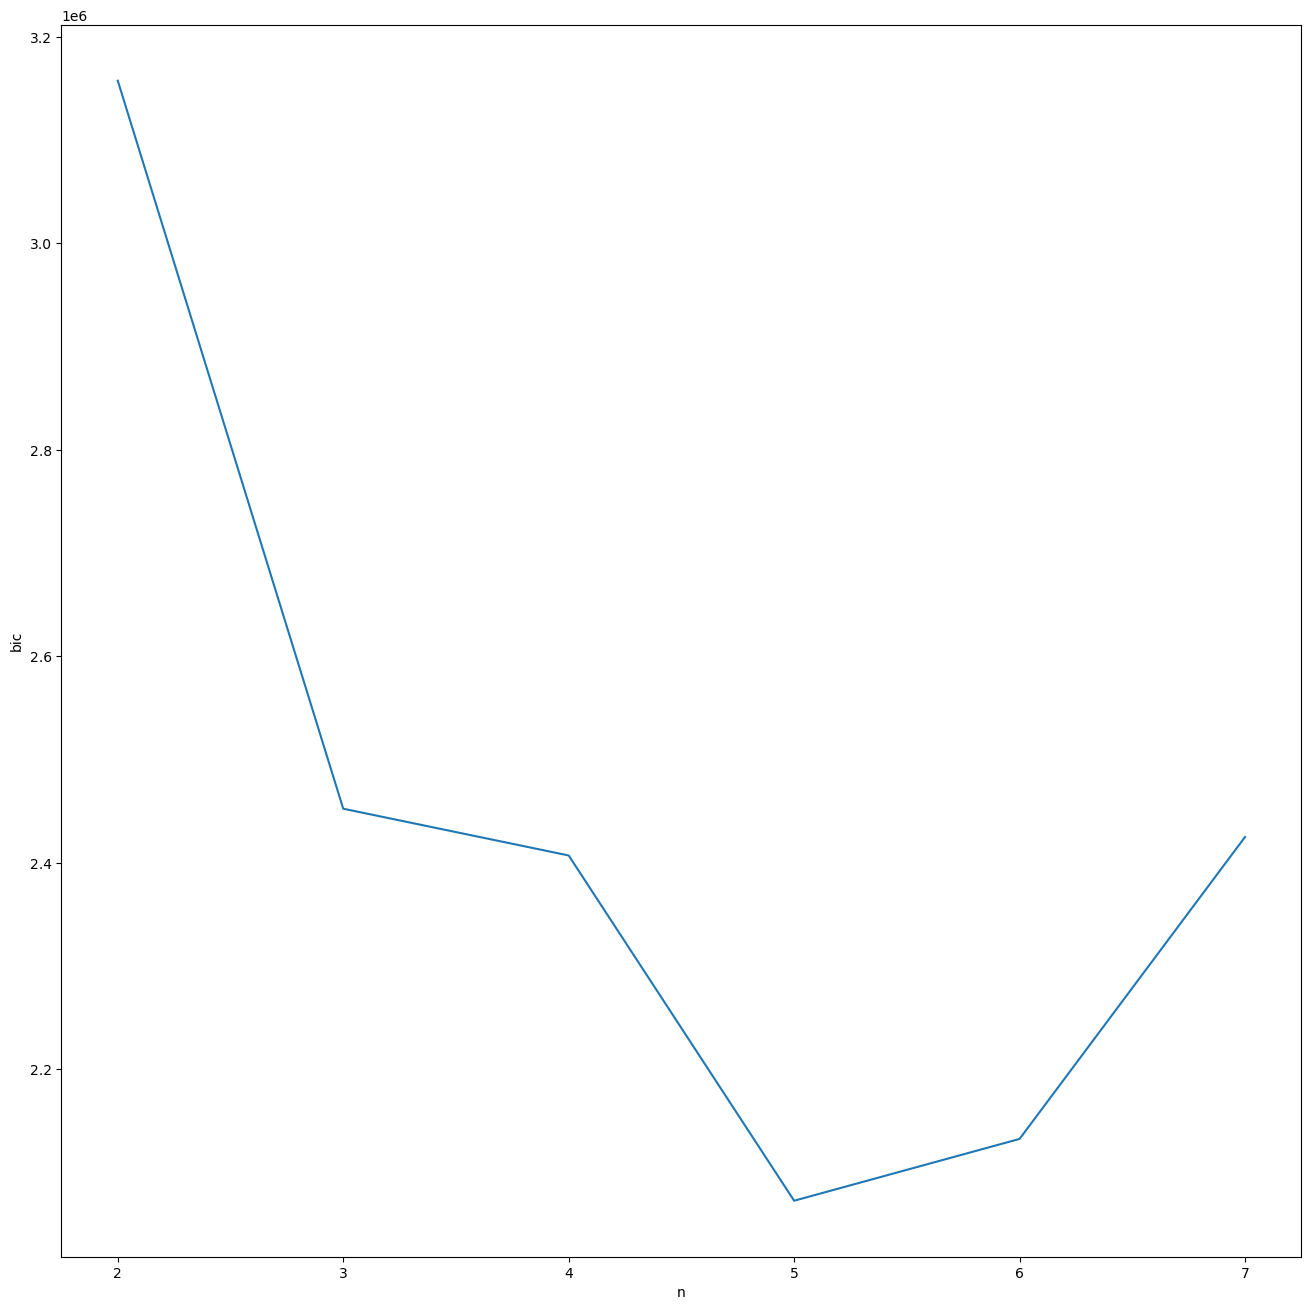

In [53]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.lineplot(ax=ax, x='n', y='bic', data=bic)
# plt.savefig('../files/complete_BIC.pdf')

### Gaussian Mixture Model

In [54]:
n = 5  # illustrative - always base the number on a reasonable estimation of the optimal number of components
n_init = 5  # more initialization, more stable clustering gets

gmm = GaussianMixture(n_components=n, covariance_type="full", max_iter=200, n_init=n_init, verbose=1)
fitted = gmm.fit(data)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
Initialization converged: True


In [55]:
labels = gmm.predict(data)

In [ ]:
pd.Series(labels, index=data.index).to_csv('../files/cluster_labels.csv')

#### Hierachical clustering

Finally, we create hierarchical classification - taxonomy.

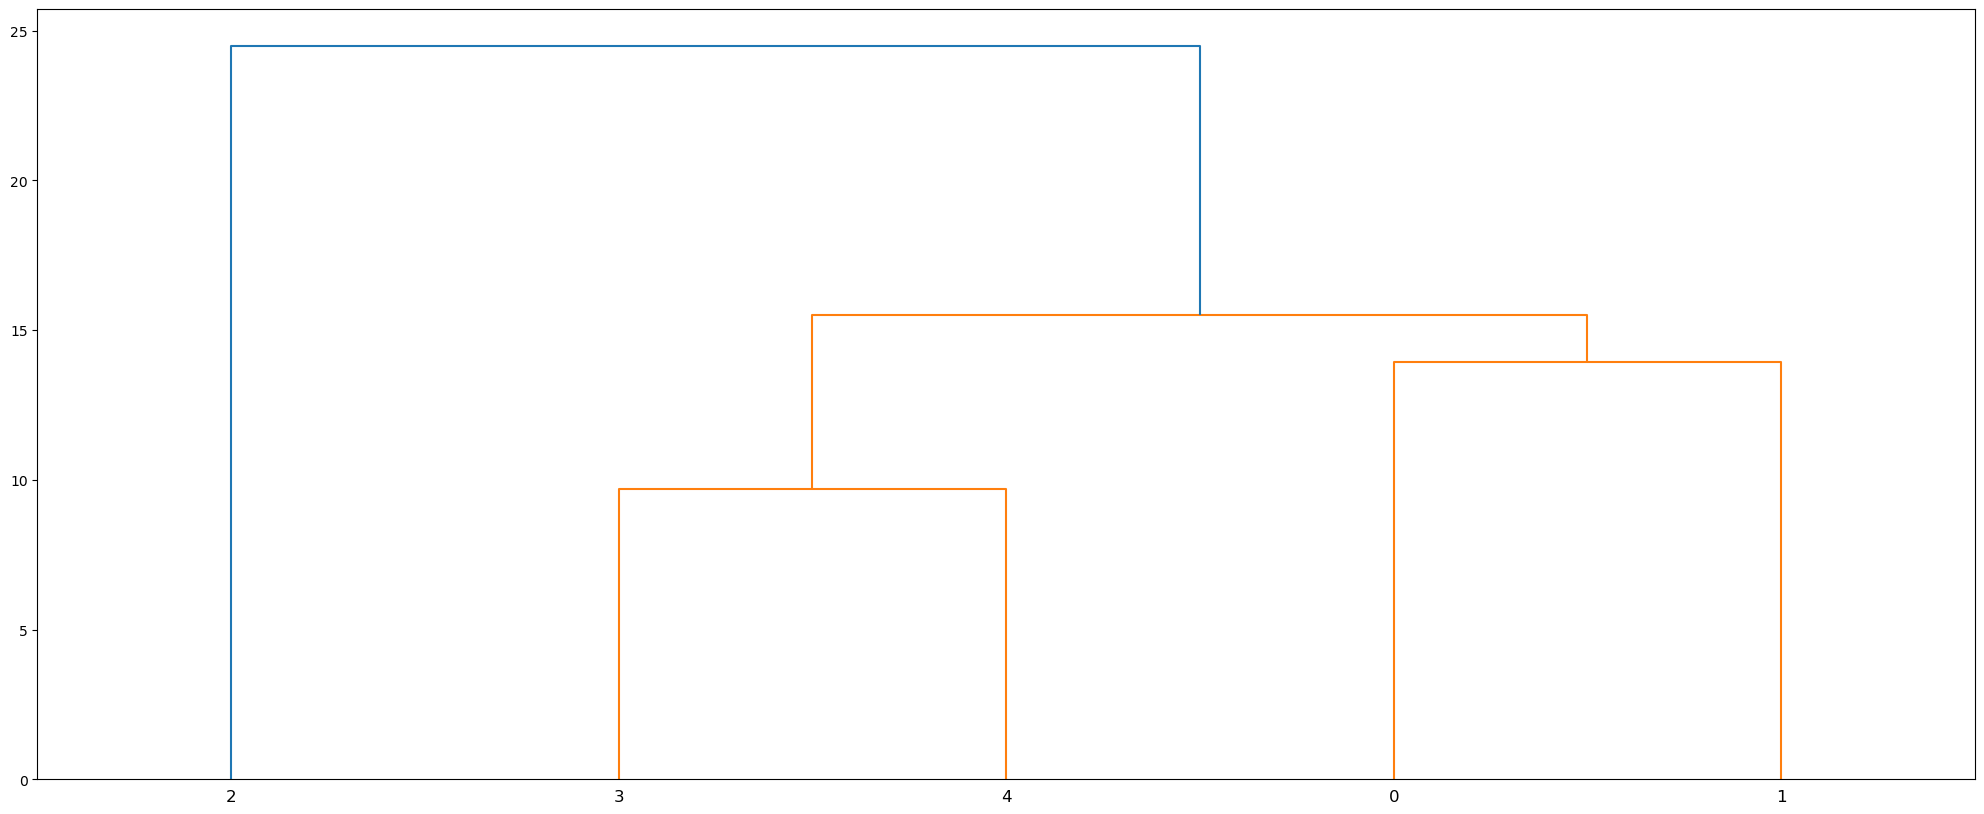

In [56]:
group = data.groupby(labels).mean()
Z = hierarchy.linkage(group, 'ward')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, labels=group.index)

# plt.savefig('tree.pdf')

## Results

<Axes: >

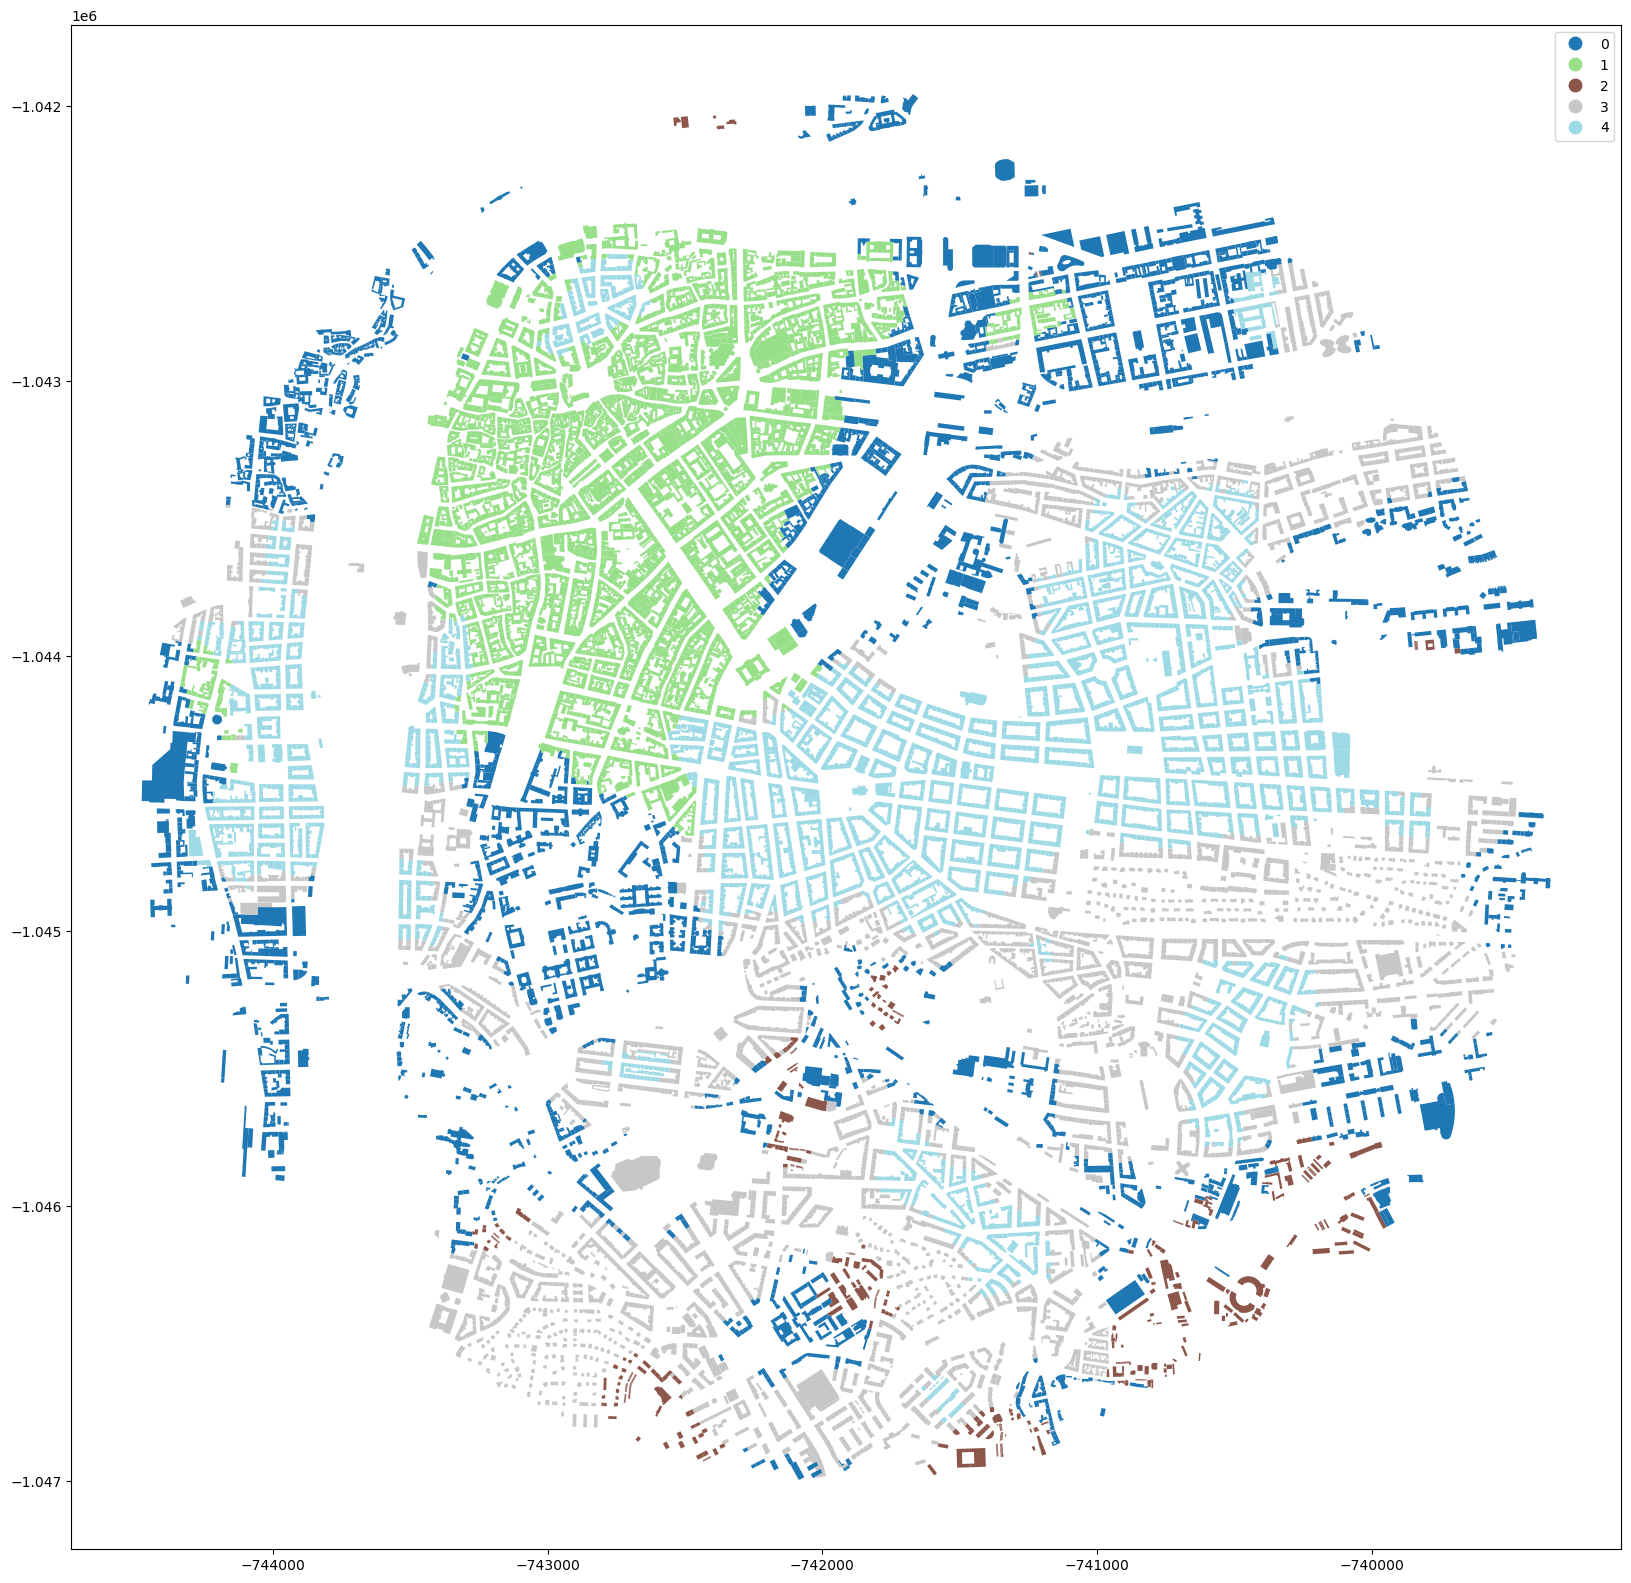

In [57]:
buildings.plot(labels, categorical=True, cmap='tab20', legend=True, figsize=(20, 20))